In [82]:
#Loading modules

import deepchem as dc
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Features
from rdkit.Chem import Fragments as fr
from rdkit.Chem import rdMolDescriptors
import tensorflow as tf

import pandas as pd

from matplotlib import pyplot as plt

import numpy as np

from sklearn import metrics
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

# Ensemble learning


In [83]:
#First lets take Richard's featurisation method (shortened):

#Loading the datasets
datasets = dc.molnet.load_tox21(featurizer='GraphConv', splitter='random')


tasks, datasets, transformers = datasets



#Transforming dataset into a pandas dataframe
train_dataset, valid_dataset, test_dataset = datasets

train_df = train_dataset.to_dataframe()
test_dataset = test_dataset.to_dataframe()
valid_dataset = valid_dataset.to_dataframe()

#This line concatenates all the dataframes, we will resplit them later with SKLEARN
dataset = pd.concat([train_df, test_dataset, valid_dataset])

dataset

,X,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,w4,w5,w6,w7,w8,w9,w10,w11,w12,ids
0,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.056284,1.147522,1.055366,1.027673,0.000000,1.037877,0.000000,1.191992,1.067100,FCOC(C(F)(F)F)C(F)(F)F
1,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.056284,1.147522,1.055366,1.027673,1.197585,1.037877,1.060569,1.191992,1.067100,ClCCCCl
2,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.147522,1.055366,1.027673,1.197585,1.037877,1.060569,1.191992,1.067100,Nc1ccc2ccccc2c1
3,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.056284,1.147522,1.055366,1.027673,1.197585,1.037877,1.060569,1.191992,1.067100,CCCOC(=O)c1ccccc1C(=O)OCCC
4,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.056284,1.147522,1.055366,1.027673,1.197585,1.037877,1.060569,1.191992,1.067100,O=c1nc([O-])n(Cl)c(=O)n1Cl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.056284,1.147522,1.055366,1.027673,1.197585,1.037877,1.060569,1.191992,1.067100,C[C@H](CCC(=O)[O-])[C@H]1CC[C@H]2[C@H]3[C@H](C...
779,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.056284,1.147522,1.055366,1.027673,1.197585,1.037877,1.060569,1.191992,1.067100,O=C(N[C@H](CO)[C@H](O)c1ccc([N+](=O)[O-])cc1)C...
780,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.056284,1.147522,1.055366,1.027673,1.197585,1.037877,1.060569,1.191992,1.067100,O=C1OC(=O)C2CC=CCC12
781,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,1.055366,0.000000,6.061118,0.000000,0.000000,6.208556,15.903226,CCCC[Sn](CCCC)(OC(C)=O)OC(C)=O


In [84]:
#Lets take just the y values and concatenate them into a single value (1 = toxic, 0 = non-toxic)

dataset = dataset[['ids', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7']]

dataset['tox'] = dataset.sum(axis=1)
dataset['tox_bin'] = dataset['tox'].apply(lambda x: 1 if x > 0 else 0)

dataset.iloc[1:100]

,ids,y1,y2,y3,y4,y5,y6,y7,tox,tox_bin
1,ClCCCCl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,Nc1ccc2ccccc2c1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
3,CCCOC(=O)c1ccccc1C(=O)OCCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,O=c1nc([O-])n(Cl)c(=O)n1Cl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,O=C(Oc1ccccc1)Oc1ccccc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
95,CC(C)(C)c1cccc(O)c1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
96,COS(=O)(=O)[O-].C[N+]1(C)CCCCC1COC(=O)C(O)(c1c...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
97,Nc1nc[nH]n1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
98,CSC(C)(C)/C=N\O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [85]:
#Next lets featurise our dataset using Richard's featurisation method
#However I will only take the top most toxic functional groups

toxic_grps = {
    'isothiocyanate' : fr.fr_isothiocyan,
    'C_S': fr.fr_C_S,
    'dihydropyridine' : fr.fr_dihydropyridine,
    'nitro_arom' : fr.fr_nitro_arom,
    'phenol_not_ortho': fr.fr_phenol_noOrthoHbond,
    'nitro_non_ortho' : fr.fr_nitro_arom_nonortho,
    'phenol' : fr.fr_phenol,
    'aromatic_OH': fr.fr_Ar_OH,
    'furan' : fr.fr_furan,
    'terminal_acetylene' : fr.fr_term_acetylene,
    'thiazole' : fr.fr_thiazole,
    'nitro' : fr.fr_nitro,
    'hydrazone' : fr.fr_hdrzone,
    'allylic_oxide' : fr.fr_allylic_oxid,
    'ketone': fr.fr_ketone,
    'bicyclic': fr.fr_bicyclic,
    'azo' : fr.fr_azo,
    'aromatic_N': fr.fr_ArN,
    'aliphatic_COO': fr.fr_Al_COO,
    'epoxide' : fr.fr_epoxide,
    'thiocyanate' : fr.fr_thiocyan,
    'aniline' : fr.fr_aniline,
    'alkyl_halide' : fr.fr_alkyl_halide,
    'pyridine' : fr.fr_pyridine,
    'isocyanate' : fr.fr_isocyan,
    'oxazole' : fr.fr_oxazole,
    'ketone_topliss' : fr.fr_ketone_Topliss,
    'imidazole' : fr.fr_imidazole,
    'para_hydroxylation' : fr.fr_para_hydroxylation,
    'benzene' : fr.fr_benzene,
    'thiophene' : fr.fr_thiophene,
    'hydrzine' : fr.fr_hdrzine,
    'phos_ester' : fr.fr_phos_ester,
    'phos_acid' : fr.fr_phos_acid,
}

In [86]:
featurized = dataset

SMILES_strings = dataset['ids']
mol = [Chem.MolFromSmiles(formula) for formula in SMILES_strings]

for row in featurized.index:
    molecule = mol[row]
    for grp in toxic_grps.keys():
        featurized.loc[row, grp] = toxic_grps[grp](molecule)

featurized


[21:57:47] WARNING: not removing hydrogen atom without neighbors


,ids,y1,y2,y3,y4,y5,y6,y7,tox,tox_bin,...,isocyanate,oxazole,ketone_topliss,imidazole,para_hydroxylation,benzene,thiophene,hydrzine,phos_ester,phos_acid
0,FCOC(C(F)(F)F)C(F)(F)F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ClCCCCl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Nc1ccc2ccccc2c1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
3,CCCOC(=O)c1ccccc1C(=O)OCCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,O=c1nc([O-])n(Cl)c(=O)n1Cl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,C[C@H](CCC(=O)[O-])[C@H]1CC[C@H]2[C@H]3[C@H](C...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
779,O=C(N[C@H](CO)[C@H](O)c1ccc([N+](=O)[O-])cc1)C...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
780,O=C1OC(=O)C2CC=CCC12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
781,CCCC[Sn](CCCC)(OC(C)=O)OC(C)=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [87]:
#Great, lets also add a few extra features such as halogens and heavy atoms (>F)

#This function will count the number of halogens:
def halogen_count(molecule):
    return fr.fr_halogen(molecule)

def heavy_atom_count(molecule):
    count = 0
    for atom in molecule.GetAtoms():
        if atom.GetAtomicNum() > 10:
            count += 1
    return count


halogens = [halogen_count(molecule) for molecule in mol]
heaviest_atoms = [heavy_atom_count(molecule) for molecule in mol]

featurized['halogens'] = halogens
featurized['heavy_atoms'] = heaviest_atoms
featurized

,ids,y1,y2,y3,y4,y5,y6,y7,tox,tox_bin,...,ketone_topliss,imidazole,para_hydroxylation,benzene,thiophene,hydrzine,phos_ester,phos_acid,halogens,heavy_atoms
0,FCOC(C(F)(F)F)C(F)(F)F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0
1,ClCCCCl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
2,Nc1ccc2ccccc2c1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0,0
3,CCCOC(=O)c1ccccc1C(=O)OCCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0
4,O=c1nc([O-])n(Cl)c(=O)n1Cl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,C[C@H](CCC(=O)[O-])[C@H]1CC[C@H]2[C@H]3[C@H](C...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0
779,O=C(N[C@H](CO)[C@H](O)c1ccc([N+](=O)[O-])cc1)C...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,2
780,O=C1OC(=O)C2CC=CCC12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
781,CCCC[Sn](CCCC)(OC(C)=O)OC(C)=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1


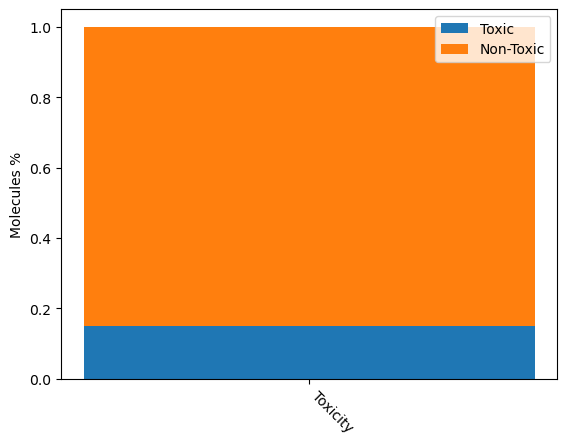

In [88]:
#We can also drop the 'y' columns

#lets first drop our 'y' values
featurized_dropped = featurized.drop(['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7'], axis=1)


#Now lets do a test train split
from sklearn.model_selection import train_test_split


train, test = train_test_split(featurized_dropped, test_size=0.2)

percent_toxic = len(train[train['tox'] == 1]) / len(train)
percent_non_toxic = 1- percent_toxic


#Lets plot the train_df as a stacked bar graph:
ax=plt.bar('Toxicity',percent_toxic, label='Toxic')
plt.bar('Toxicity',percent_non_toxic, bottom= percent_toxic, label='Non-Toxic')
plt.xticks(rotation=-45, ha='left')
plt.ylabel("Molecules %")
plt.legend()



In [165]:
#We have a heavily unbalanced dataset, lets fix that!

print(len(train[train['tox'] == 1]))
print(len(train[train['tox'] == 0]))

from sklearn.utils import resample

train_majority = train[train['tox'] == 0]
train_minority = train[train['tox'] == 1]

train_min_upsampled = resample(train_minority, 
                               replace=True, 
                               n_samples=int(len(train_majority)))

train_upsampled = pd.concat([train_majority, train_min_upsampled])
train_upsampled

942
4761


,ids,tox,tox_bin,isothiocyanate,C_S,dihydropyridine,nitro_arom,phenol_not_ortho,nitro_non_ortho,phenol,...,ketone_topliss,imidazole,para_hydroxylation,benzene,thiophene,hydrzine,phos_ester,phos_acid,halogens,heavy_atoms
937,OCC1CCC(CO)CC1,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4492,Cc1ccccc1CCl,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1
3556,CCCCC[C@H](O)/C=C/[C@H]1[C@H](O)C[C@H](O)[C@@H...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3950,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1888,O=C(Oc1ccc(Br)cc1)N1CCN2CCC1CC2,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4853,N=C(Nc1ccccc1)Nc1ccccc1,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0,0
2331,CCOP(=S)(OCC)Oc1cc(Cl)c(Br)cc1Cl,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,5
563,O=C(C=Cc1ccccc1)OCc1ccccc1,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0,0
3482,CC1CC(OC(=O)C(O)c2ccccc2)CC(C)(C)N1C,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0


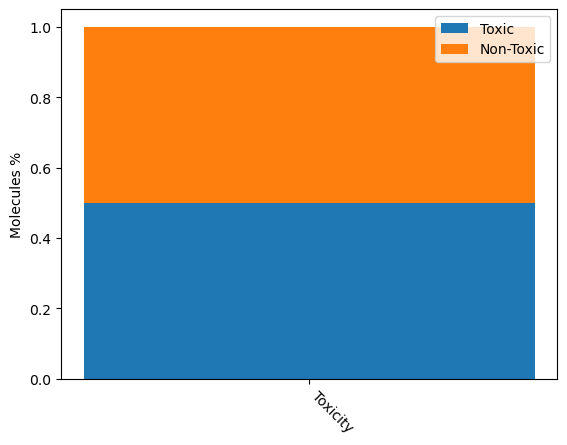

In [166]:
percent_toxic = len(train_upsampled[train_upsampled['tox'] == 1]) / len(train_upsampled)
percent_non_toxic = 1- percent_toxic


#Lets plot the train_df as a stacked bar graph:
ax=plt.bar('Toxicity',percent_toxic, label='Toxic')
plt.bar('Toxicity',percent_non_toxic, bottom= percent_toxic, label='Non-Toxic')
plt.xticks(rotation=-45, ha='left')
plt.ylabel("Molecules %")
plt.legend()

In [167]:
#Thats better, lets now split our data into X and y

train_X = train_upsampled.drop(['ids'], axis=1).drop(['tox'], axis=1).drop(['tox_bin'], axis=1)
train_y = train_upsampled['tox_bin']

test_X = test.drop(['ids'], axis=1).drop(['tox'], axis=1).drop(['tox_bin'], axis=1)
test_y = test['tox_bin']

train_X

,isothiocyanate,C_S,dihydropyridine,nitro_arom,phenol_not_ortho,nitro_non_ortho,phenol,aromatic_OH,furan,terminal_acetylene,...,ketone_topliss,imidazole,para_hydroxylation,benzene,thiophene,hydrzine,phos_ester,phos_acid,halogens,heavy_atoms
937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1
3556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0,0
2331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,5
563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0,0
3482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0


In [168]:
#Lets see how balanced the dataset is:
train_y.value_counts()

0    4761
1    4761
Name: tox_bin, dtype: int64

In [169]:
#Lets first train a simple SGD Classifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

#We should first scale our data
train_X = StandardScaler().fit_transform(train_X)
test_X = StandardScaler().fit_transform(test_X)

sgd = SGDClassifier()
sgd.fit(train_X, train_y)

SGDClassifier()

In [170]:
cross_val_score(sgd, test_X, test_y, cv =5, scoring='accuracy')

array([0.69426752, 0.65605096, 0.7284345 , 0.68051118, 0.65814696])

In [171]:
#Thats not too bad, lets compare it to a random classifier

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(train_X, train_y)

cross_val_score(dummy_clf, test_X, test_y, cv =5, scoring='accuracy')

array([0.7388535 , 0.7388535 , 0.74121406, 0.73801917, 0.73801917])

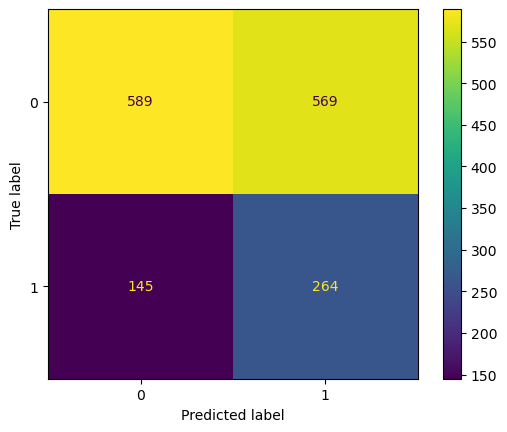

In [172]:
#Lets look at our confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(test_y, sgd.predict(test_X))

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

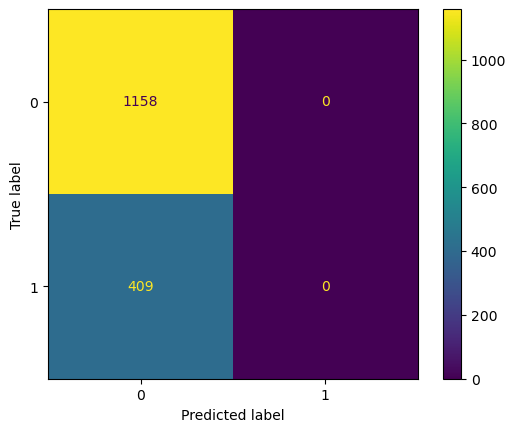

In [173]:
cm_dummy = confusion_matrix(test_y, dummy_clf.predict(test_X))

ConfusionMatrixDisplay(confusion_matrix=cm_dummy).plot()

In [174]:
#Hmm, these arent very good, lets train a random forest:

from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(train_X, train_y)


RandomForestClassifier()

In [175]:
cross_val_score(rf_clf, test_X, test_y, cv =5, scoring='accuracy')

array([0.74203822, 0.70700637, 0.71565495, 0.73162939, 0.71884984])

Model score: 0.37330037082818285


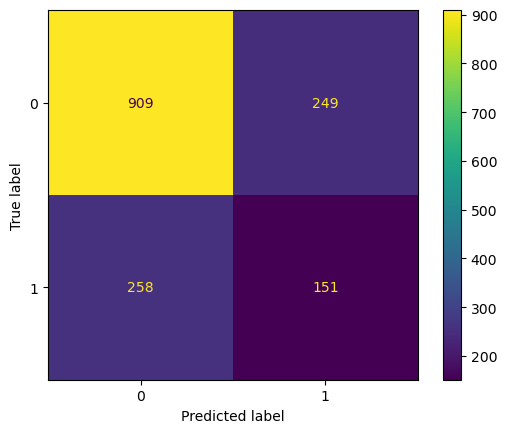

In [176]:
from sklearn.metrics import f1_score
predicted = rf_clf.predict(test_X)

score = f1_score(test_y, predicted)
cm = confusion_matrix(test_y, predicted)

print(f'Model score: {score}')
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [177]:
#Lets see if we can optimise this using GridSearchCV

from sklearn.model_selection import GridSearchCV


In [178]:

rf_clf = RandomForestClassifier(criterion='gini', max_features='log2')

grid = {
    'n_estimators': [150, 250, 350],
    'max_depth' : [7,8, 9, 10],
}


grid_search = GridSearchCV(estimator=rf_clf, param_grid=grid)

grid_search.fit(train_X, train_y)

GridSearchCV(estimator=RandomForestClassifier(max_features='log2'),
             param_grid={'max_depth': [7, 8, 9, 10],
                         'n_estimators': [150, 250, 350]})

In [179]:
grid_search.best_params_

{'max_depth': 10, 'n_estimators': 250}

In [180]:
rf_clf = RandomForestClassifier(**grid_search.best_params_)
rf_clf.fit(train_X, train_y)

RandomForestClassifier(max_depth=10, n_estimators=250)

In [181]:
pred = rf_clf.predict(test_X)

score = f1_score(test_y, pred)
print(f'f1 score: {score}')

f1 score: 0.4323232323232323


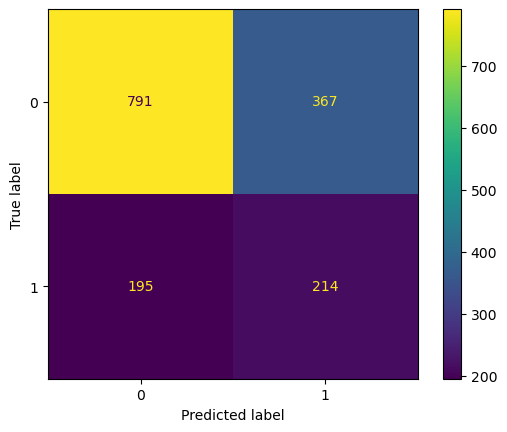

In [182]:
cm = confusion_matrix(test_y, pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Text(0.5, 1.0, 'Precision Recall Curve')

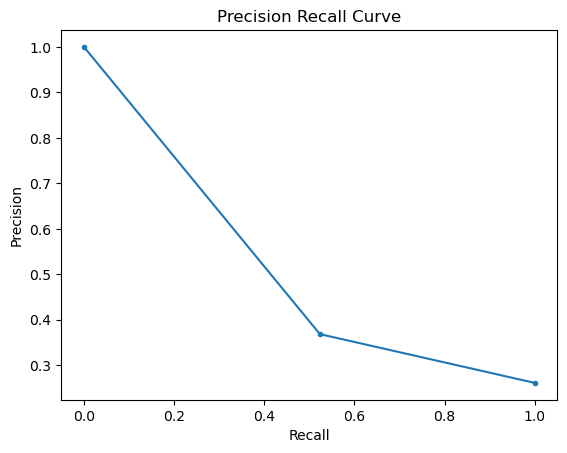

In [183]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(test_y, pred)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')

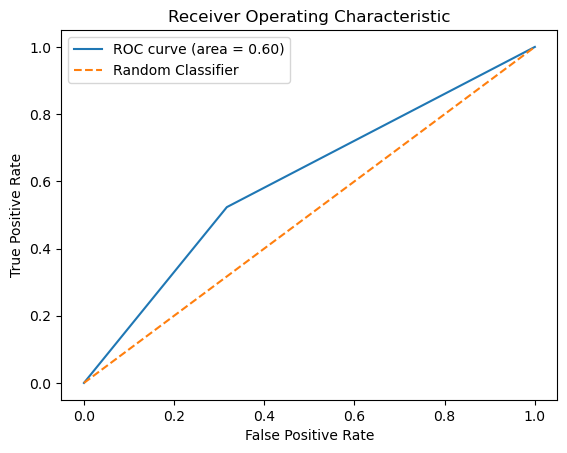

In [184]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_y, pred)

roc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()

In [185]:
from sklearn.svm import SVC

#Lets train an SVC classifier
svc_clf = SVC(probability=True)
svc_clf.fit(train_X, train_y)

y_pred = svc_clf.predict(test_X)
score = f1_score(test_y, y_pred)
print(f'f1 score: {score}')

f1 score: 0.39293598233995586


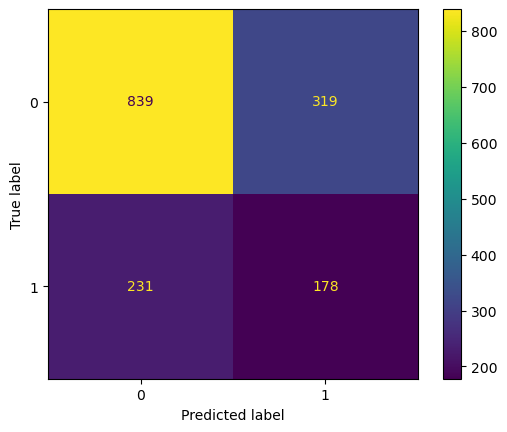

In [186]:
#This isn't too bad, lets look at the confusion matrix

cm = confusion_matrix(test_y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [187]:
#We can see the biggest error is from false positives which isn't too bad for us
#We can set this threshold ourselves to reduce the false negatives even further:

class_probability = svc_clf.predict_proba(test_X)

threshold = 0.45
y_pred = np.where(class_probability[:,1] > threshold, 1, 0)
score = f1_score(test_y, y_pred)
print(f'f1 score: {score}')

f1 score: 0.44058500914076776


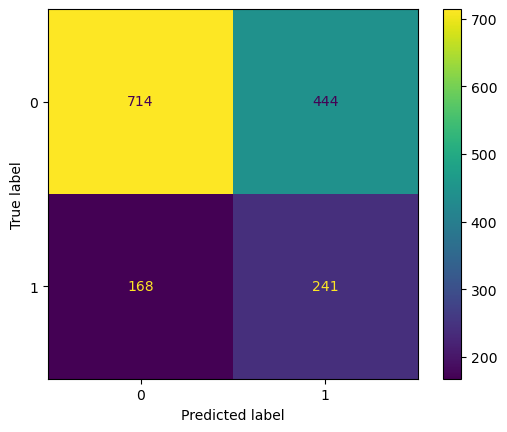

In [188]:
cm = confusion_matrix(test_y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [189]:
#As you can see we have decreased the number of false negatives but 
#increased the number of false positives. Setting the threshold is a balanci9ng act

In [190]:
#Lets try another classifier:
#K nearest neighbors:

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(train_X, train_y)

KNeighborsClassifier()

In [191]:
y_pred = knn.predict(test_X)

score = f1_score(test_y, y_pred)
print(f'f1 score: {score}')

f1 score: 0.38989898989898997


In [192]:
#Lets do another grid search:

grid = {
    'n_neighbors': [3, 5, 7],
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}

grid_clf = GridSearchCV(knn, grid, cv=5)
grid_clf.fit(train_X, train_y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']})

In [193]:
grid_clf.best_estimator_

KNeighborsClassifier(metric='euclidean', weights='distance')

In [194]:
best_knn = grid_clf.best_estimator_

y_pred = best_knn.predict(test_X)

score = f1_score(test_y, y_pred)
print(f'f1 score: {score}')

f1 score: 0.37122002085505734


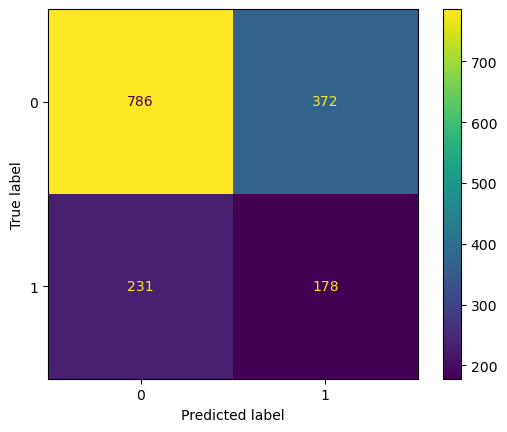

In [195]:
cm = confusion_matrix(test_y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [196]:
from sklearn.naive_bayes import GaussianNB

nb_clf = GaussianNB()

nb_clf.fit(train_X, train_y)

GaussianNB()

In [197]:
y_pred = nb_clf.predict(test_X)

score = f1_score(test_y, y_pred)
print(f'f1 score: {score}')

f1 score: 0.416867469879518


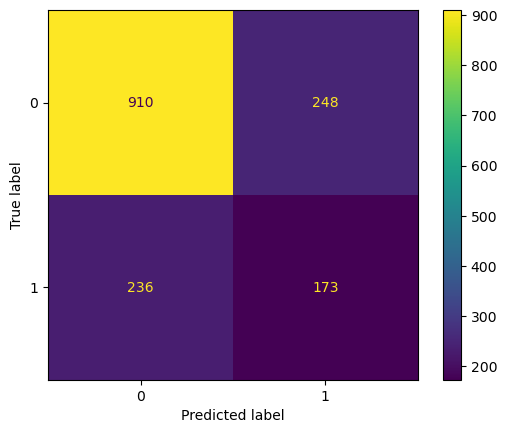

In [198]:
cm = confusion_matrix(test_y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [199]:
#Now lets try to ensemble them all together!

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


clf1 = LogisticRegression()
clf2 = DecisionTreeClassifier()
clf3 = GaussianNB()
clf4 = KNeighborsClassifier()
clf5 = SVC()
clf6 = rf_clf

ensemble = VotingClassifier(
    estimators=[('lr', clf1), 
                ('dt', clf2), 
                ('nb', clf3), 
                ('knn', clf4), 
                ('svc', clf5), 
                ('rf', clf6)], voting='hard')

ensemble.fit(train_X, train_y)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('dt', DecisionTreeClassifier()),
                             ('nb', GaussianNB()),
                             ('knn', KNeighborsClassifier()), ('svc', SVC()),
                             ('rf',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=250))])

In [200]:
from sklearn.metrics import accuracy_score

y_pred = ensemble.predict(test_X)

acc = accuracy_score(test_y, y_pred)
score = f1_score(test_y, y_pred)
print(f'f1 score: {score} \n accuracy score: {acc}')


f1 score: 0.3843236409608091 
 accuracy score: 0.6892150606253988


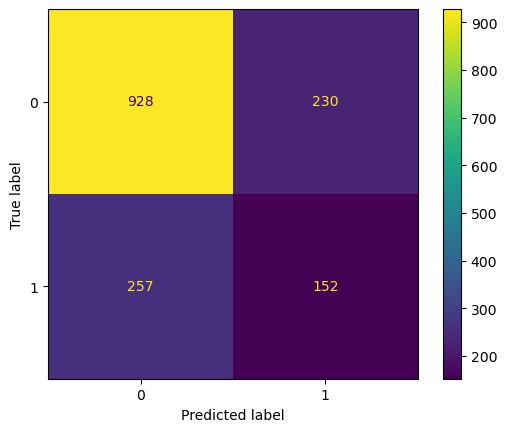

In [201]:
cm = confusion_matrix(test_y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()